In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification

# Data Preparation


Prepare the data to be used with kNN

In [2]:
plots = [("traces/normal/", 'grid9_normal_2019-02-13_17:05'),
         ("traces/1bh-3/", 'grid9_1bh-3_2019-02-13_16:28'),
         ("traces/1bh-5/", 'grid9_1bh-5_2019-02-13_15:31'),
         ("traces/1bh-6/", 'grid9_1bh-6_2019-02-13_12:59'),
         ("traces/1bh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1bh-9/", 'grid9_1bh-9_2019-02-13_15:57'),
         ("traces/1gh-3/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-5/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-6/", 'grid_1gh-6_2019-02-15_18:25'),
         ("traces/1gh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1gh-9/", 'grid_1gh-9_2019-02-15_19:19'),
         ("traces/rnd-1/", 'rnd_1bh-2_2019-02-14_15:38'),
         ("traces/rnd-1/", 'rnd_1bh-7_2019-02-14_13:57'),
         ("traces/rnd-1/", 'rnd_1bh-9_2019-02-14_15:15'),
         ("traces/rnd-1/", 'rnd_1gh-2_2019-02-16_08:37'),
         ("traces/rnd-1/", 'rnd_1gh-7_2019-02-16_10:16'),
         ("traces/rnd-1/", 'rnd_1gh-9_2019-02-16_10:36'),
         ("traces/rnd-1/", 'rnd_normal_2019-02-14_13:37'),
         ("traces/rnd-2/", 'rnd-2_1gh-3_2019-02-16_11:41'),
         ("traces/rnd-2/", 'rnd2_1bh-3_2019-02-14_17:02'),
         ("traces/rnd-2/", 'rnd2_1bh-6_2019-02-15_16:56'),
         ("traces/rnd-2/", 'rnd2_1bh-8_2019-02-15_17:28'),
         ("traces/rnd-2/", 'rnd2_normal_2019-02-14_16:07')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[1].split('_')[1]
    
    # Assign a label
    if row[1].find('gh') >= 0 or row[1].find('bh') >= 0:
        label = 'Attacked'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7404:4:404:,normal,141,339.276596,85174.044377,291.845926,2,106.0,1563.0,0.295,9,Normal
1,aaaa::212:7405:5:505:,normal,178,392.123596,28083.058084,167.580005,3,197.0,1557.0,0.110,9,Normal
2,aaaa::212:7407:7:707:,normal,151,486.913907,68843.959205,262.381324,3,214.0,1623.0,0.245,7,Normal
3,aaaa::212:7406:6:606:,normal,176,315.613636,40342.752727,200.855054,2,129.0,1144.0,0.120,12,Normal
4,aaaa::212:740a:a:a0a:,normal,181,497.646409,66065.140945,257.031401,4,260.0,1945.0,0.095,9,Normal


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

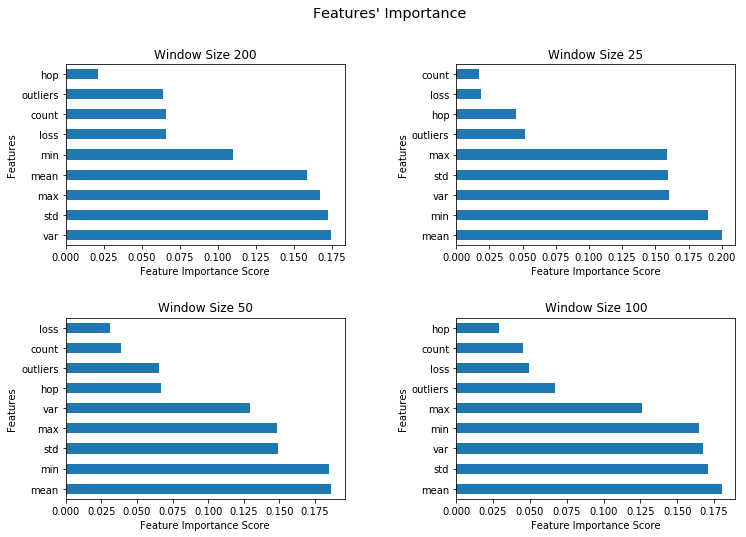

In [3]:
plots_analysis.random_forests_features_selection(trace_stats)

In [8]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [9]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [10]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

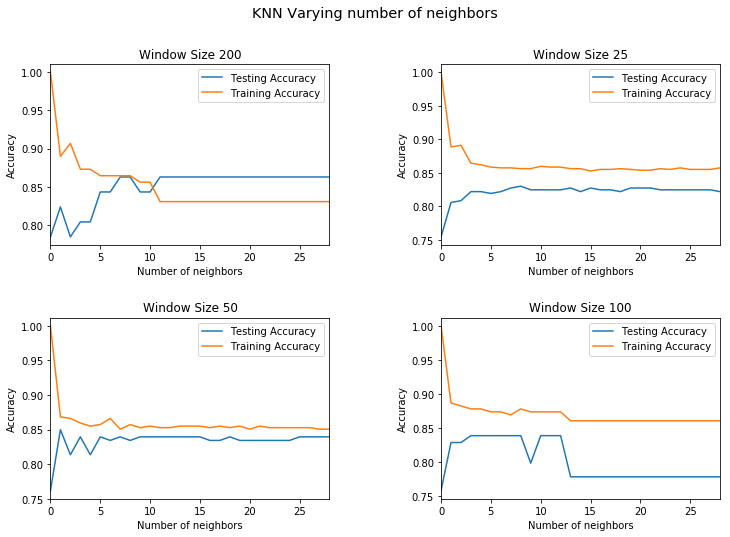

In [11]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [12]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [13]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [14]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='linear')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [15]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='linear')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [16]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 25


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 50


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Cross validate

In [17]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Computing trace 25


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 50


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Computing trace 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Results

Results from each model

In [21]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.803922,0.586039,0.586039,0.586039,0.079783,0.007446
1,Random Forest,25,0.832884,0.727652,0.571858,0.583840,0.137028,0.009868
2,Random Forest,50,0.860104,0.808702,0.626989,0.660411,0.108536,0.009054
3,Random Forest,100,0.818182,0.787088,0.623377,0.646429,0.073782,0.007120
4,KNN,200,0.843137,0.430000,0.488636,0.457447,0.001072,0.005773
5,KNN,25,0.824798,0.693524,0.531321,0.517941,0.002278,0.011012
6,KNN,50,0.839378,0.795635,0.542330,0.536668,0.001139,0.006718
7,KNN,100,0.838384,0.913978,0.636364,0.667227,0.001706,0.006819
8,SVM,200,0.764706,0.551587,0.563312,0.555233,22.276839,0.008142
9,SVM,25,0.776280,0.474700,0.489940,0.470155,180.733884,0.001769


Here we plot the average results for each model computed with cross validation

In [19]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.839827
1,Random Forest,25,0.837915
2,Random Forest,50,0.831444
3,Random Forest,100,0.841288
4,KNN,200,0.851948
5,KNN,25,0.837112
6,KNN,50,0.845567
7,KNN,100,0.844508
8,SVM,200,0.721385
9,SVM,25,0.786037
